In [164]:
import pandas as pd 
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score


In [2]:
pd.set_option('display.max_columns', None)

In [107]:
df = pd.read_csv('dataset.csv',index_col=0)

# Prepare data

In [108]:
int_cols = df.select_dtypes(include=['int', 'float']).columns
obj_cols = ['country','network_name','sex','is_cheater','has_email']

In [109]:
def prepare_obj_data(df, obj_cols):
    '''
    Подготовка колонрк с типом данных object
    
    Arg:
        df: pd.DataFrame
        obj_col: str 
    Return:
        pd.DataFrame
    '''
    label_encoder = LabelEncoder()
    for column in df[obj_cols]:
        encoded_column = label_encoder.fit_transform(df[column])
        new_column_name = column + "_level"
        df[new_column_name] = encoded_column
    df.drop(obj_cols,axis=1,inplace=True)
        
    return df 
    
    

In [110]:
df.shape

(250006, 39)

In [111]:
df = prepare_obj_data(df, obj_cols)

In [115]:
df.drop(['date_install','first_command_time','birthday','time_confirm_email'],axis=1,inplace=True)

In [118]:
X = df.drop('target_game_currency', axis = 1)
y = df['target_game_currency']

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Linear Regression

In [130]:
def plot_importance(model, X):
    '''
    Функция строит график feature importance
    '''
    try:
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X.columns
        fold_importance_df["importance"] = model.coef_
        td = fold_importance_df.sort_values('importance', ascending=False)
        sns.barplot(x="importance", y="feature", data=td.head(10), palette="Blues_d")
        plt.show()
    except:
        return []

In [168]:
def SMAPE(y_true, y_pred):
    ''''
    SMAPE score 
    '''
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

def custom_smape_score(estimator, X, y):
    '''
    SMAP для кросс-валидациий
    '''
    y_pred = estimator.predict(X)
    smape = SMAPE(y, y_pred)
    return -smape

In [162]:
def train_model(model_obj, X_train, y_train, num_folds ,cross_val = False):
    '''
    Обучение модели 
    '''
    model = model_obj
    print(model.fit(X_train, y_train))
    
    if cross_val:
        cv_scores = cross_val_score(model, X_train, y_train, cv = num_folds, scoring = custom_smape_score)
        print("Cross_validation:", cv_scores)
    
    td = plot_importance(model, X_train)
    
    return model, td

LinearRegression()
Cross_validation: [-197.33299961 -197.27341228 -197.32454265 -197.11359762 -197.27340425]


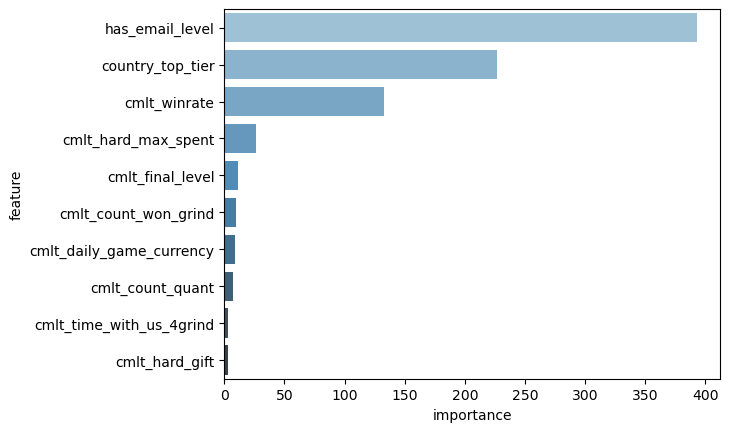

In [167]:
model, features = train_model(LinearRegression(),
                                X_train, 
                                y_train,
                                5,
                                cross_val=True)

In [169]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [170]:
print('Train SMAPE: ', SMAPE(y_train, y_pred_train))
print('Test SMAPE: ', SMAPE(y_test, y_pred_test))

Train SMAPE:  197.24879989846818
Test SMAPE:  197.2894963496791
